In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# data_dir = '/content/drive/MyDrive/Dataset/Face Shape Dataset/train'
data_dir = '/content/drive/MyDrive/Dataset/Face Shape Dataset/train2'

img_height, img_width = 200, 200
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=4
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=4
)

Found 1353 images belonging to 4 classes.
Found 336 images belonging to 4 classes.


In [ ]:
train_generator.class_indices

{'heart': 0, 'oblong': 1, 'round': 2, 'square': 3}

In [ ]:
classes = list(train_generator.class_indices.keys())
classes

['heart', 'oblong', 'round', 'square']

In [ ]:
pd.Series(train_generator.classes).value_counts()

,count
1,367
2,332
0,329
3,325


# Build CNN model

In [ ]:
def create_face_shape_model(num_classes, input_shape=(200, 200, 3), embedding_dim=128):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2, strides=2)(x)
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2, strides=2)(x)
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    # Embedding layer
    embedding = layers.Dense(embedding_dim, name='embedding')(x)

    # Classification layer
    outputs = layers.Dense(num_classes, activation='softmax')(embedding)

    # Create models
    full_model = models.Model(inputs=inputs, outputs=outputs, name='face_shape_classifier')
    embedding_model = models.Model(inputs=inputs, outputs=embedding, name='face_shape_embedding')

    return full_model, embedding_model

In [ ]:
num_classes = len(train_generator.class_indices)

classifier_model, embedding_model = create_face_shape_model(num_classes=num_classes)

classifier_model.summary()
classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "face_shape_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_69 (MaxPooling2D)      │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (None, 25, 25, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_70 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 6, 6, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_71 (MaxPooling2D)      │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 256)                 │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,900 (534.77 KB)

 Trainable params: 136,900 (534.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
epochs = 100
batch_size = 32

early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=12,
    verbose=1,
    restore_best_weights=True
)

history = classifier_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - accuracy: 0.2688 - loss: 1.3938 - val_accuracy: 0.2469 - val_loss: 1.3964
Epoch 2/100
 1/42 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3125 - loss: 1.3700

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3125 - loss: 1.3700 - val_accuracy: 0.1875 - val_loss: 1.3945
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.2678 - loss: 1.3842 - val_accuracy: 0.2750 - val_loss: 1.3842
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.3739 - val_accuracy: 0.1875 - val_loss: 1.3914
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.2923 - loss: 1.3818 - val_accuracy: 0.2688 - val_loss: 1.3856
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 1.3894 - val_accuracy: 0.3125 - val_loss: 1.3584
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.3033 - loss: 1.3705 - val_accuracy: 0.2500 - val_loss: 1.3790
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4688 - loss: 1.3138 - val_accuracy: 0.2500 - val_loss: 1.4286
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.3480 - loss: 1.3319 - val_accuracy: 0.2937 - va

In [ ]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = classifier_model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.4888 - loss: 2.9570
Validation Loss: 3.0106
Validation Accuracy: 0.4494


In [ ]:
# Get predictions on the validation set
validation_generator.reset()
y_pred = classifier_model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step


In [ ]:
# Generate classification report
class_names = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       heart       0.27      0.22      0.24        82
      oblong       0.30      0.37      0.33        91
       round       0.25      0.24      0.25        82
      square       0.26      0.25      0.25        81

    accuracy                           0.27       336
   macro avg       0.27      0.27      0.27       336
weighted avg       0.27      0.27      0.27       336



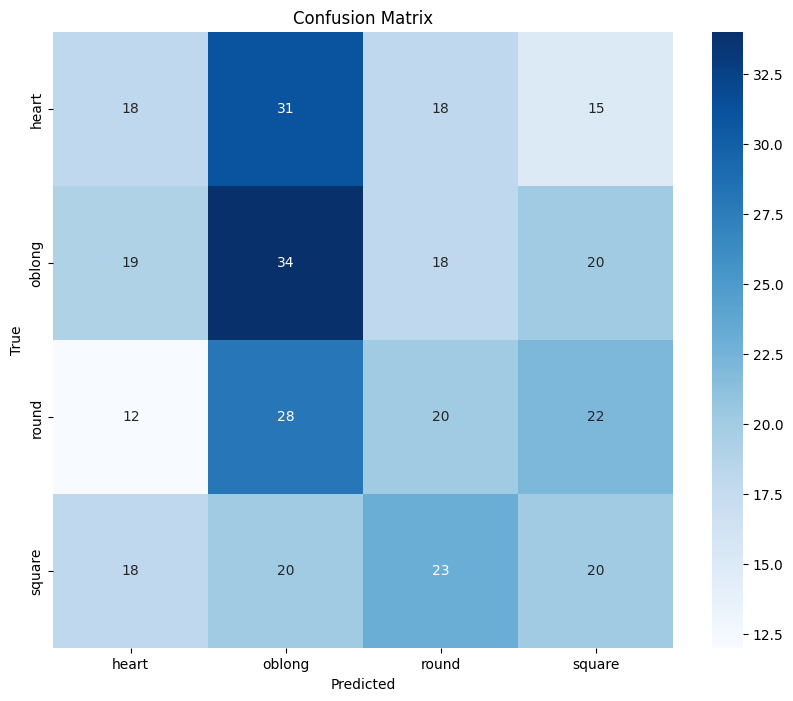

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

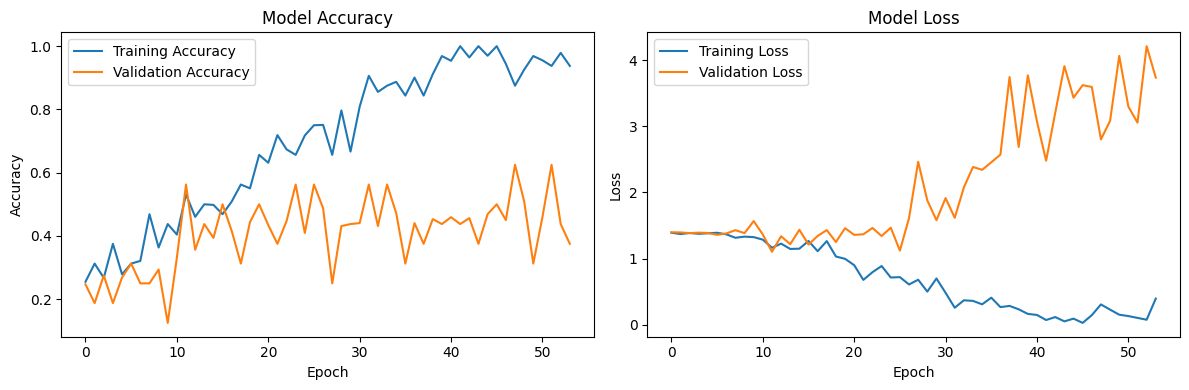

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
classes = list(train_generator.class_indices.keys())

def predict_face_shape(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.
    predicts = classifier_model.predict(img_array)
    predicted_class = classes[np.argmax(predicts)]
    return predicted_class

In [ ]:
predict_face_shape('/content/drive/MyDrive/Dataset/Face Shape Dataset/test/heart (777).jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


'square'

In [ ]:
def get_face_shape_embedding(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.
    embedding = embedding_model.predict(img_array)
    return embedding[0]

In [ ]:
get_face_shape_embedding('/content/drive/MyDrive/Dataset/Face Shape Dataset/train/square/square (849).jpg').shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


(128,)

In [ ]:
# Save the models
embedding_model.save('face_shape_embedding_model.h5')
classifier_model.save('face_shape_classifier_model.h5')

print("Models saved successfully.")

Models saved successfully.


# Crop face from image

In [ ]:
import dlib
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt

In [ ]:
def detect_faces(image):
    face_detector = dlib.get_frontal_face_detector()

    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]

    return face_frames

In [ ]:
def crop_faces_with_padding(image, face_rects, padding=20):
    cropped_faces = []
    for face_rect in face_rects:
        left, top, right, bottom = face_rect

        left = max(0, left - padding)
        top = max(0, top - padding - 10)
        right = min(image.shape[1], right + padding)
        bottom = min(image.shape[0], bottom + padding)

        face = Image.fromarray(image).crop((left, top, right, bottom))
        cropped_faces.append(face)

    return cropped_faces

In [ ]:
img_path = '/content/9979.jpg'
image = io.imread(img_path)

detected_faces = detect_faces(image)
cropped_faces = crop_faces_with_padding(image, detected_faces)

# Save cropped faces
for n, face in enumerate(cropped_faces):
    face.save(img_path + '_cropped_face.jpg', 'JPEG')

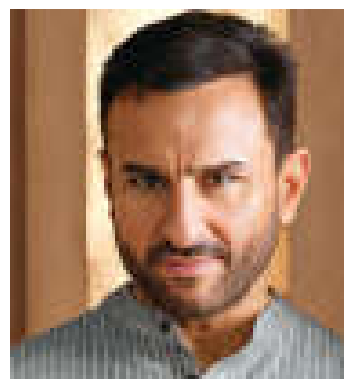

In [ ]:
# Plot the cropped faces
for n, face in enumerate(cropped_faces):
    plt.subplot(1, len(cropped_faces), n + 1)
    plt.axis('off')
    plt.imshow(face)

plt.show()

In [ ]:
predict_face_shape('/content/9979.jpgcropped_face.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


'round'